Number of samples left: 9298
Mean Squared Error: 22.347893390217408
R-squared: 0.7555098832696223
Regression Function:
y = 0.87 + 1.14 * max_level_24h + 0.48 * revenue_24h
Coefficient for max_level_24h: 1.140427069896396
Coefficient for revenue_24h: 0.4824874642414624
Intercept: 0.8712932797787118


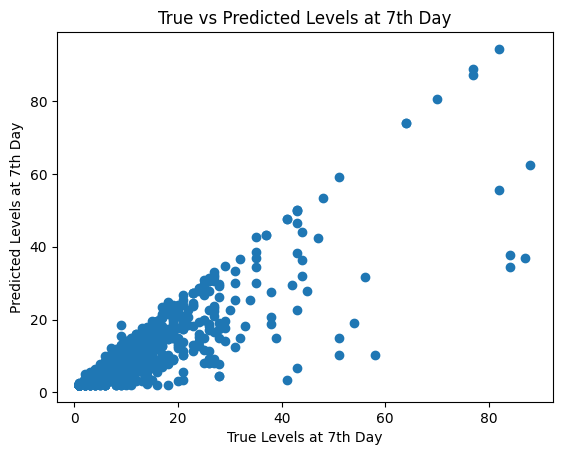

In [1]:
import os
import pandas as pd
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set up the environment 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/magic/Downloads/ds-interview-sca.json'  # Update it your key path

# BigQuery client
client = bigquery.Client()

# BigQuery Integration
query = """
WITH
  user_activity AS (
    SELECT
      user_id,
      platform,
      country,
      event_name,
      level_name,
      ad_revenue,
      TIMESTAMP_SECONDS(CAST(FLOOR(event_timestamp / 1000000) AS INT64)) AS event_time,
      DATE(TIMESTAMP_SECONDS(CAST(FLOOR(event_timestamp / 1000000) AS INT64))) AS event_date,
      installed_datetime,
      TIMESTAMP(installed_datetime) AS install_time
    FROM
      `analytics_v2.clustered_events`
    WHERE
      platform = 'ios'
      AND country = 'us'
      AND event_timestamp IS NOT NULL
      AND user_id IS NOT NULL
      
  ),
  user_first_24h AS (
    SELECT
      user_id,
      MAX(level_name) AS max_level_24h,
      SUM(ad_revenue) AS revenue_24h 
    FROM
      user_activity
    WHERE
      TIMESTAMP_DIFF(event_time, install_time, HOUR) <= 24
    GROUP BY
      user_id
  ),
  user_first_7d AS (
    SELECT
      user_id,
      MAX(level_name) AS max_level_7d,
      SUM(ad_revenue) AS revenue_7d
    FROM
      user_activity
    WHERE
      TIMESTAMP_DIFF(event_time, install_time, DAY) <= 7
    GROUP BY
      user_id
  )
SELECT
  u24.user_id,
  u24.max_level_24h,
  u7.max_level_7d,
  u24.revenue_24h,
  u7.revenue_7d
FROM
  user_first_24h u24
LEFT JOIN
  user_first_7d u7
ON
  u24.user_id = u7.user_id
WHERE
  u24.max_level_24h <= 100 AND u7.max_level_7d <= 100  -- Exclude users with levels above 100
ORDER BY
  u24.user_id;
"""

# DataFrame
df = client.query(query).to_dataframe()

# Check for NaN values in X and y
X = df[['max_level_24h', 'revenue_24h']]  # Features: max level at 24 hours, revenue at 24 hours
y = df['max_level_7d']  # Target: max level at 7 days

# Drop rows with missing values in X, ensure y matches
X = X.dropna()
y = y[X.index]


print(f"Number of samples left: {X.shape[0]}")

if X.shape[0] > 0:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # linear regression model
    model = LinearRegression()

    # 
    model.fit(X_train, y_train)

    # Predict the levels for the test data
    y_pred = model.predict(X_test)

    # Evaluate using Mean Squared Error (MSE) and R-squared (R2)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Extract regression coefficients and intercept
    intercept = model.intercept_
    coefficients = model.coef_
    features = X.columns

    # Display the regression equation
    print("Regression Function:")
    print(f"y = {intercept:.2f} + {coefficients[0]:.2f} * max_level_24h + {coefficients[1]:.2f} * revenue_24h")

    # Display each coefficient alongside the feature it corresponds to
    for feature, coef in zip(features, coefficients):
        print(f"Coefficient for {feature}: {coef}")

    print(f"Intercept: {intercept}")

    # Plot the true vs predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Levels at 7th Day")
    plt.ylabel("Predicted Levels at 7th Day")
    plt.title("True vs Predicted Levels at 7th Day")
    plt.show()
else:
    print("Not enough data to train the model.")
